In [1]:
# %matplotlib notebook
%matplotlib inline
import os
import re

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from minimum.linear.plot_tools import extract_primal_dual_results, extract_scs_results
import minimum.linear.data.util

The path to the NETLIB problems and log files. The log files are generated by the "netlib" C++ example program.

In [2]:
path = minimum.linear.data.util.get_directory() + os.sep + "netlib" + os.sep

Define a few helper functions for extracting data from the log text and create convergence plots.

In [3]:
def extract_ground_truth(s):
    pattern = r'Solution should be (-?\d+\.?\d*e?[-+]?\d*)'
    return float(re.search(pattern, s).group(1))

def plot_file(name):
    s = open(path + name + ".SIF.log").read()
    iteration, objective, infeasibility, time = extract_primal_dual_results(s)
    try:
        ground_truth = extract_ground_truth(s)
    except:
        print(name, " does not have ground truth.")
        return
    
    objective = np.array(objective)
    objective_error = abs(objective - ground_truth) / abs(ground_truth)
    
    primal_dual_status = "?"
    if "PRIMAL-DUAL INFEASIBLE" in s:
        primal_dual_status = "INFEASIBLE"
    elif "PRIMAL-DUAL NONOPTIMAL" in s:
        primal_dual_status = "NONOPTIMAL"
    elif "PRIMAL-DUAL OK" in s:
        primal_dual_status = "OK"
        
    scs_status = "?"
    if "SCS INFEASIBLE" in s:
        scs_status = "INFEASIBLE"
    elif "SCS NONOPTIMAL" in s:
        scs_status = "NONOPTIMAL"
    elif "SCS OK" in s:
        scs_status = "OK" 
    
    plt.figure(figsize=(5, 2.8))
    plt.hold(True)
    plt.loglog(time, objective_error, ".-", label="Primal-dual objective error")
    plt.loglog(time, infeasibility, ":", label="Primal-dual Infeasibility")
    plt.xlabel("Time")
    plt.title(name + " (" + primal_dual_status + ", " + scs_status + ")")
    
    scs_iteration, scs_objective, scs_gap, scs_time = extract_scs_results(s)
    scs_iteration = np.array(scs_iteration)
    scs_objective = np.array(scs_objective)
    scs_gap = np.array(scs_gap)
    scs_time = np.array(scs_time)
    
    if len(scs_iteration) == 0:
        print(name, "does not have SCS.")
    
    ind = []
    for i in range(len(scs_iteration)):
        if scs_iteration[i] in iteration:
            ind.append(i)
    scs_objective = scs_objective[ind]
    scs_iteration = scs_iteration[ind]
    scs_gap = scs_gap[ind]
    scs_time = scs_time[ind]       
    
    scs_objective_error = abs(scs_objective - ground_truth) / abs(ground_truth)
    scs_objective_error[scs_objective_error > 1e3] = 1e3
    plt.loglog(scs_time, scs_objective_error, ".-", label="SCS objective error")
    plt.loglog(scs_time, scs_gap, ":", label="SCS duality gap")
    
    plt.legend();

Plot every log file found in the directory.

E226  does not have ground truth.


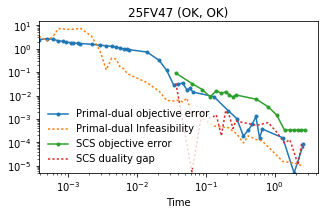

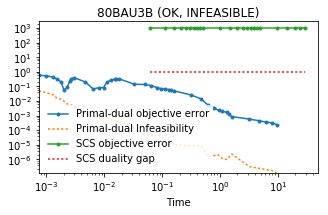

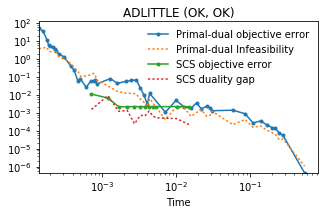

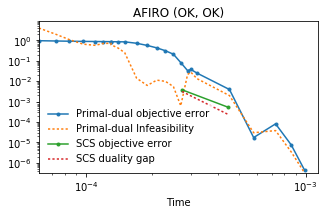

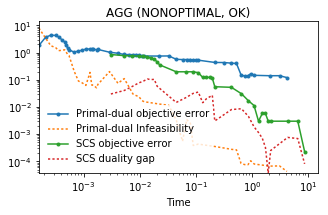

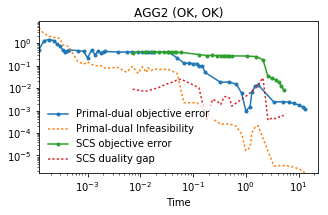

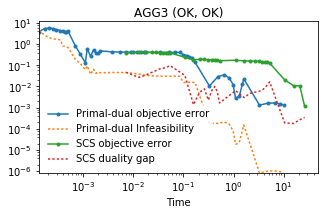

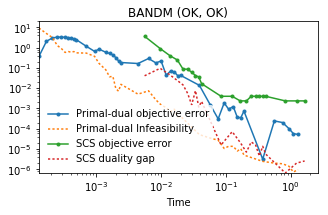

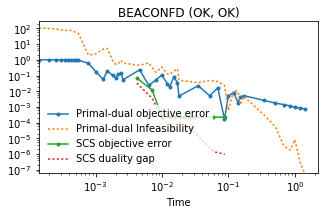

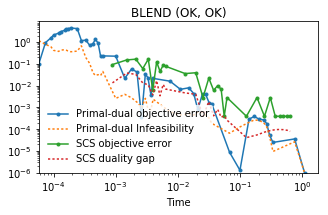

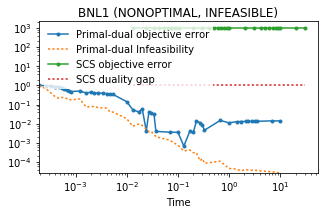

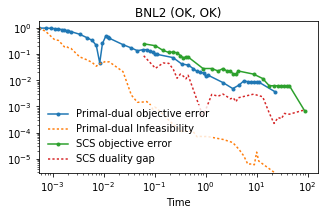

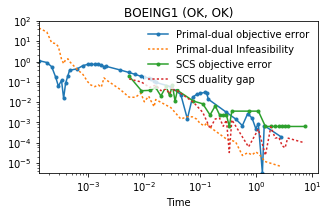

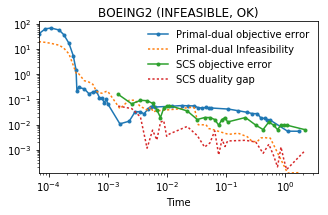

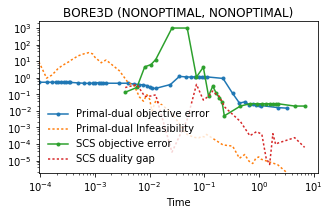

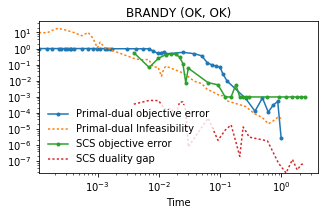

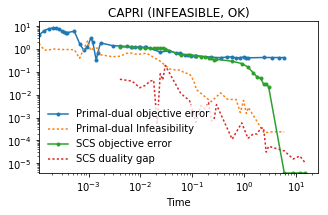

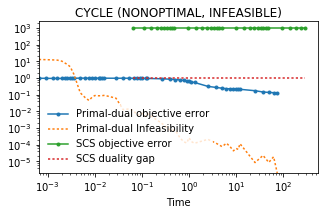

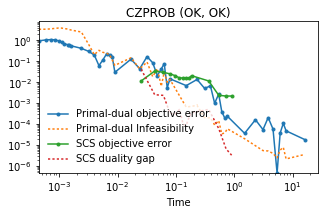

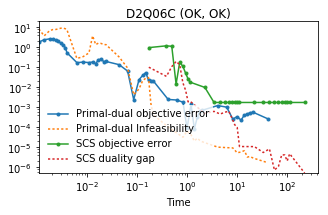

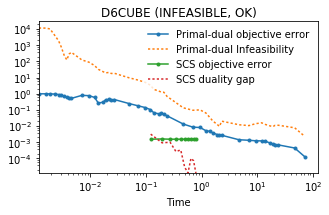

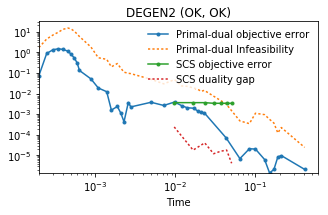

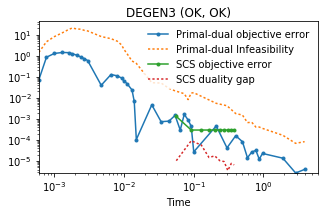

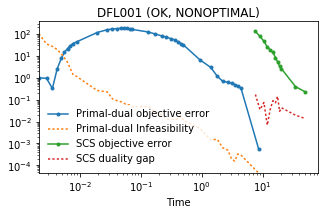

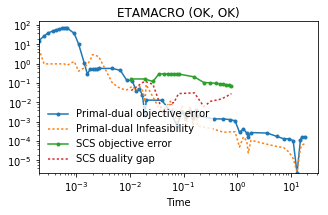

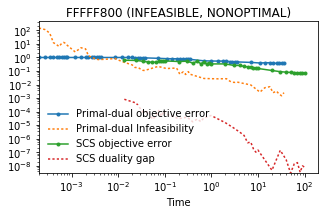

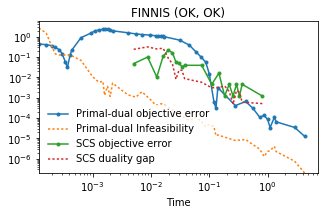

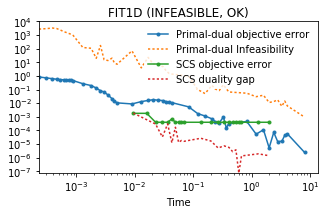

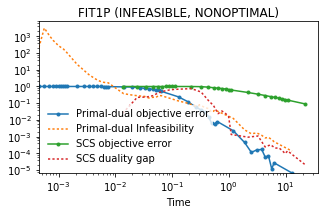

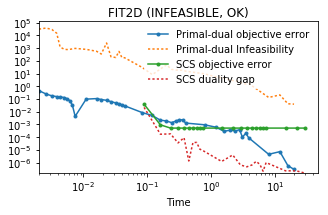

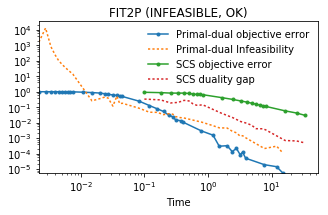

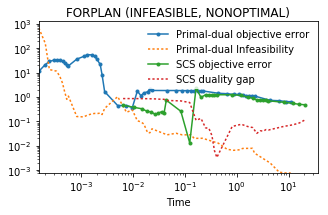

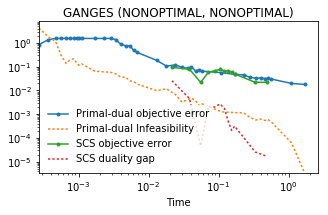

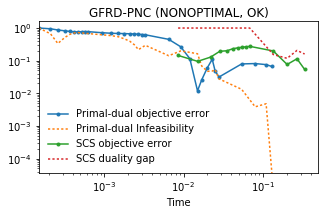

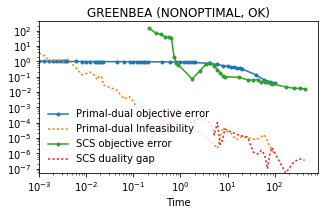

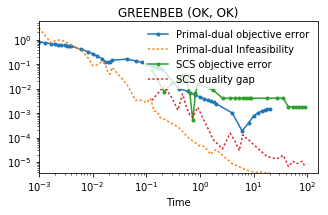

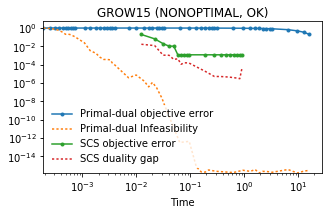

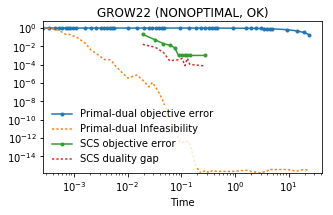

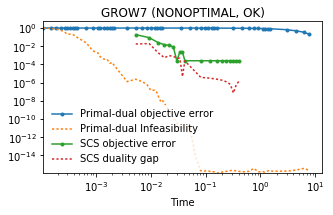

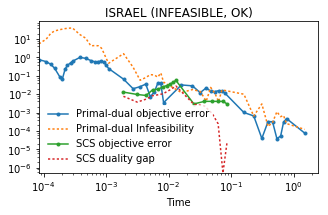

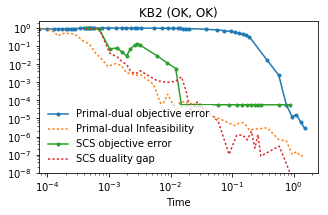

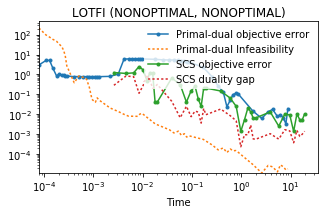

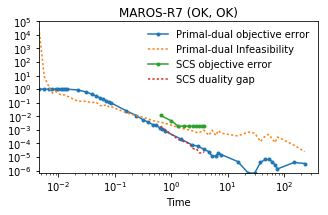

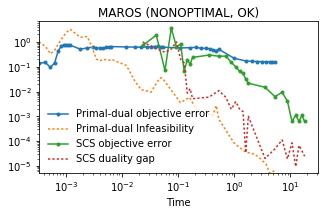

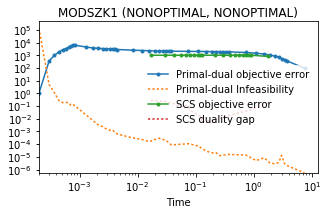

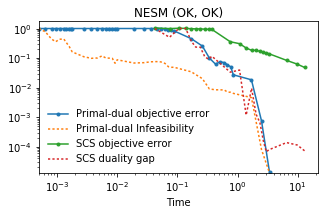

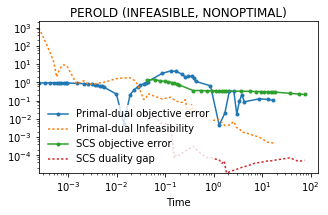

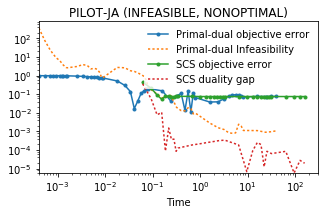

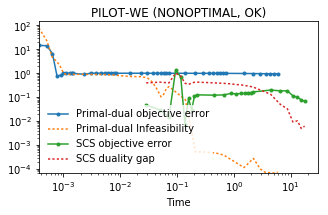

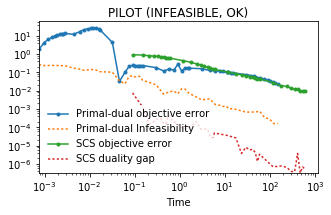

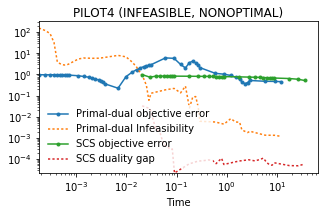

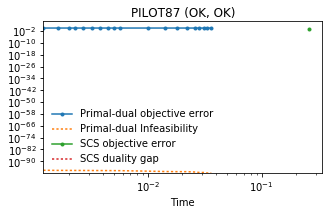

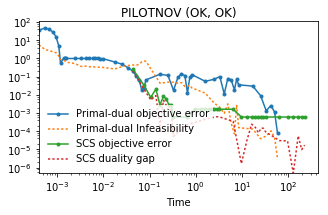

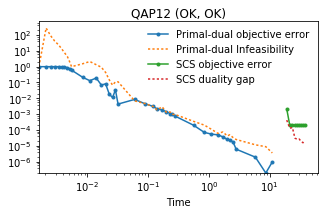

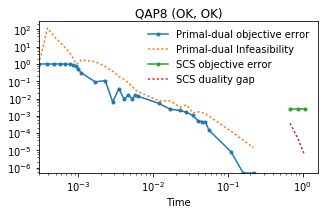

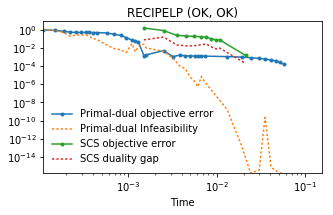

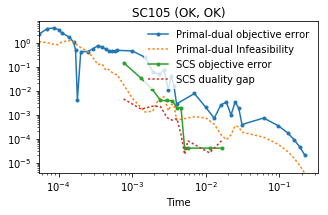

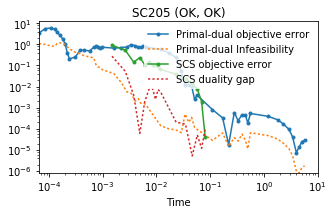

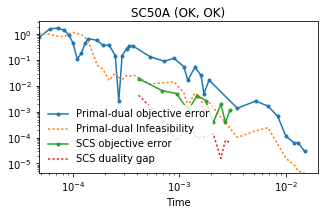

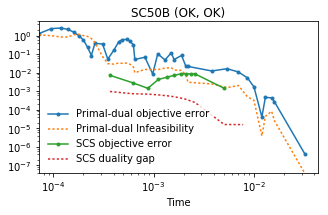

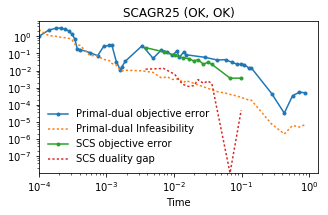

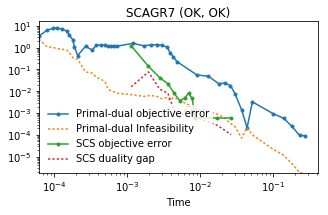

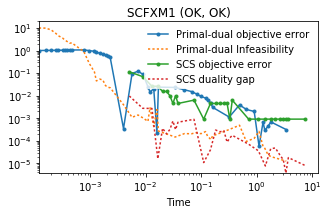

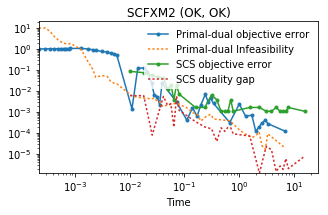

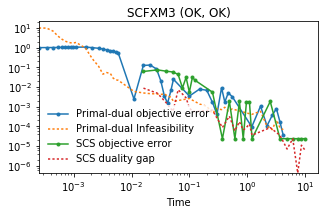

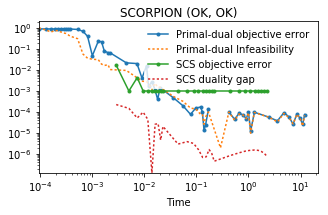

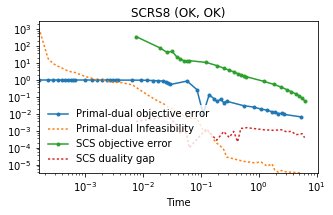

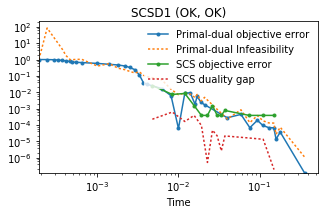

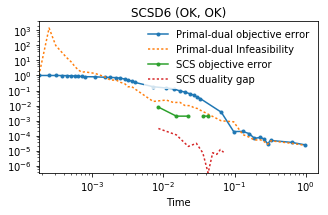

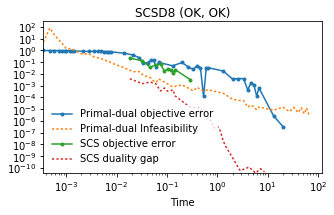

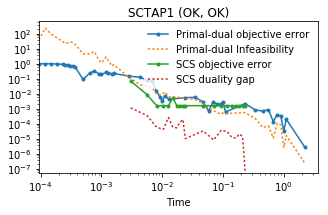

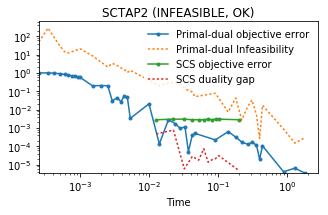

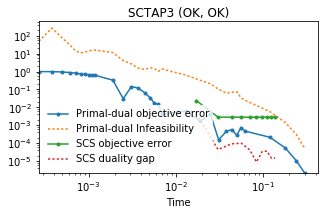

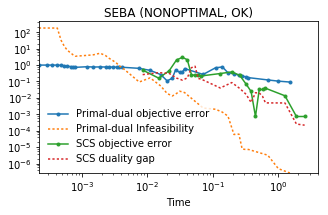

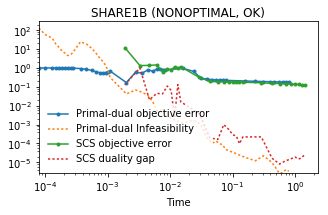

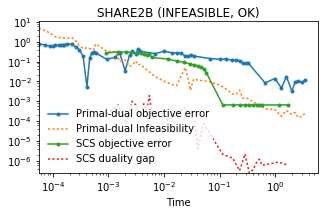

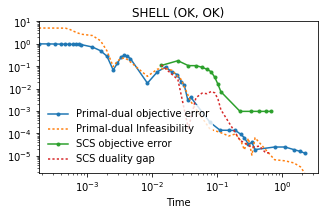

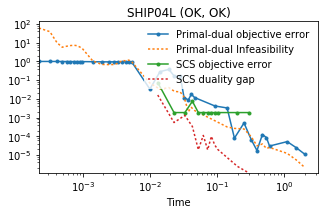

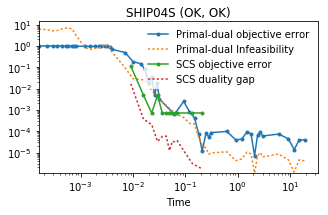

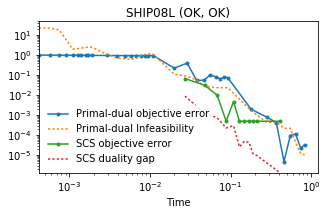

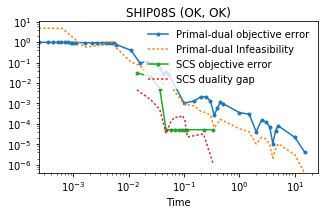

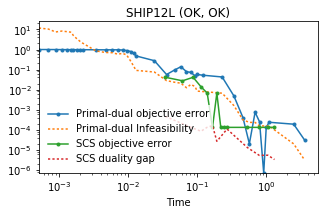

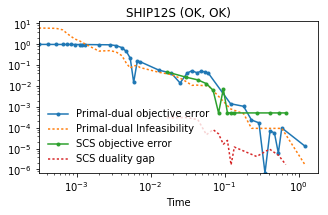

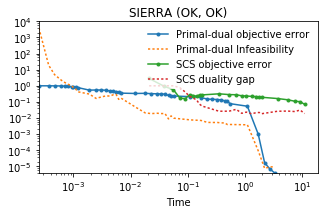

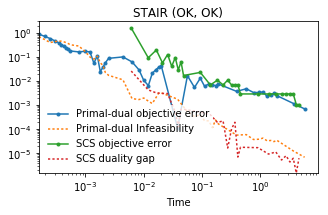

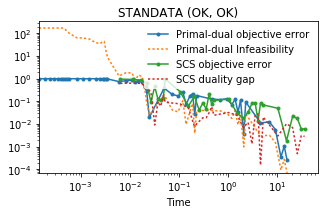

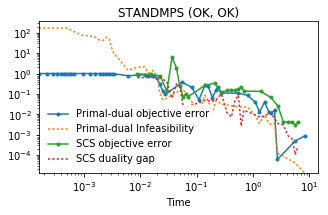

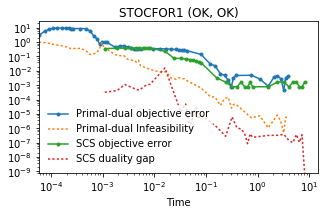

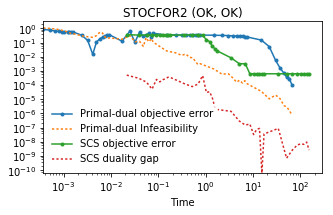

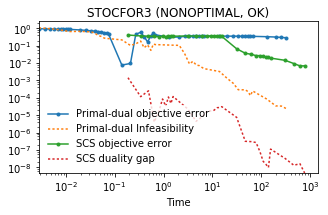

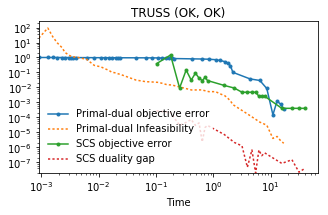

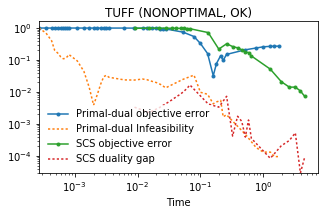

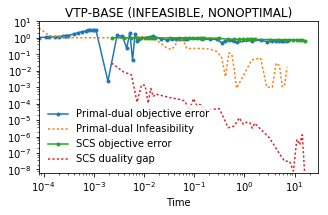

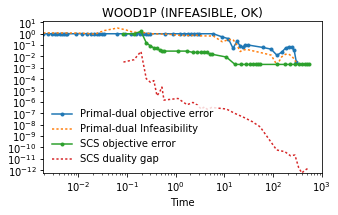

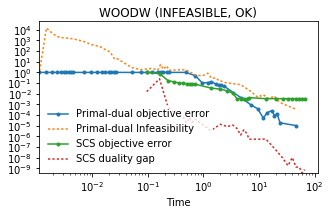

In [4]:
matplotlib.rcParams["figure.max_open_warning"] = 200

for f in os.listdir(path):
    if f.endswith(".log"):
        name = f.split(".")[0]
        plot_file(name)